In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
import pickle
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

Import data

In [19]:
# puffing factor for gaussian errors
puff = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.3, 1.0, 1.0])

# import data (with speczs)
flux_sigmas = np.load('data/flux_errors_no_missing.npy')*(1e9)*puff # units: nanomaggies
fluxes = np.load('data/fluxes_no_missing.npy')*1e9 # units: nanomaggies
zspec = np.load('data/zspec_no_missing.npy')
zb = np.load('data/zb_no_missing.npy')
specsource = np.load('data/specsource_no_missing.npy')

# cut out dodgy values
cut = (fluxes < 1e9).all(axis=1) * (zspec < 2.0) * (zspec > 1e-3) * (specsource != 'CDFS') * (specsource != 'VVDS')
fluxes = fluxes[cut,:]
flux_sigmas = flux_sigmas[cut,:]
zspec = zspec[cut]
zb = zb[cut]
specsource = specsource[cut]

In [20]:
# weights
logits = tf.Variable(np.array([-0.67778176, -1.1752868 , -1.6953907]).astype(np.float32))

# location parameters
locs = tf.Variable(np.array([0.11383244, 0.28379175, 0.532703]).astype(np.float32))

# scale parameters
scales = tf.Variable(np.array([0.05216346, 0.10501441, 0.09464115]).astype(np.float32))

# skewness and tailweight parameters
skewness = tf.Variable(np.array([0.23342754,  0.401639  , -0.001292]).astype(np.float32))
tailweight = tf.Variable(np.array([0.7333437, 1.6772406, 1.1508114]).astype(np.float32))

# mixture model
nz = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                          components_distribution=tfd.SinhArcsinh(loc=locs, scale=scales, skewness=skewness, tailweight=tailweight))

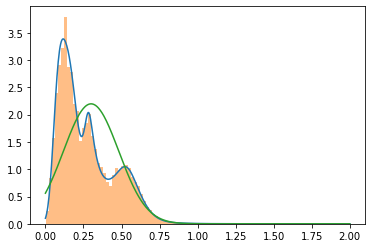

In [21]:
z = np.linspace(0, 2, 500)
pdf = nz.prob(z).numpy()
plt.plot(z, pdf)

mu = 0.3#np.median(zspec)
sig = np.std(zspec)
plt.hist(zspec, bins=100, density=True, alpha = 0.5)
plt.plot(z, norm(loc=mu, scale=sig).pdf(z))
plt.show()

Importance sample to get biased sub-sample

In [23]:
# importance weights
weights = norm(loc=mu, scale=sig).pdf(zspec) / nz.prob(zspec).numpy()
weights = weights / sum(weights)

# make the selection
ind = np.random.choice(np.arange(len(zspec)), p=weights, replace=False, size=15000)

# do the cuts
zspec_cal = zspec[ind]
fluxes_cal = fluxes[ind]
flux_sigmas_cal = flux_sigmas[ind]
specsource_cal = specsource[ind]
zb_cal = zb[ind]
zprior_sig_cal = 0.001 * np.ones(len(zspec_cal))

zspec_ = np.delete(zspec, ind)
fluxes_ = np.delete(fluxes, ind, axis=0)
flux_sigmas_ = np.delete(flux_sigmas, ind, axis=0)
specsource_ = np.delete(specsource, ind)
zb_ = np.delete(zb, ind)
zprior_sig_ = 10. * np.ones(len(zspec_cal))

zspec_all = np.concatenate([zspec_cal, zspec_])
fluxes_all = np.concatenate([fluxes_cal, fluxes_], axis=0)
flux_sigmas_all = np.concatenate([flux_sigmas_cal, flux_sigmas_], axis=0)
specsource_all = np.concatenate([specsource_cal, specsource_])
zb_all = np.concatenate([zb_cal, zb_])
zprior_sig_all = np.concatenate([zprior_sig_cal, zprior_sig_])

# now pickle everything
pickle.dump([fluxes_cal, flux_sigmas_cal, zspec_cal, specsource_cal, zb_cal, zprior_sig_cal], open('data/KV450_cut_calibration.pkl', 'wb') )
pickle.dump([fluxes_, flux_sigmas_, zspec_, specsource_, zb_, zprior_sig_], open('data/KV450_cut_main.pkl', 'wb') )
pickle.dump([fluxes_all, flux_sigmas_all, zspec_all, specsource_all, zb_all, zprior_sig_all], open('data/KV450_cut_all.pkl', 'wb') )

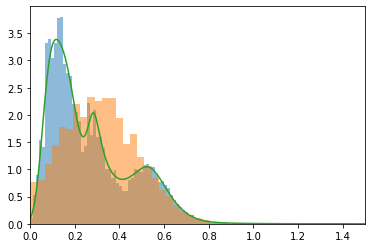

In [26]:
plt.hist(zspec_, bins=150, density=True, alpha = 0.5)
plt.hist(zspec_cal, bins=30, density=True, alpha = 0.5)
plt.plot(z, pdf)
plt.xlim(0, 1.5)
plt.show()

In [25]:
fluxes, flux_sigmas, zspec, specsource, zb, zprior_sig = pickle.load(open('data/KV450_cut_all.pkl', 'rb'))